In [12]:
import sys
print(sys.version)
import importlib

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
print(torch.cuda.is_available())


import torch

import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import random

import torch
from tqdm import tqdm


import torch.utils.data
import json
from tdc_starter_kit import utils

import pandas as pd
from tqdm.notebook import tqdm
from torch.utils.data import Subset
seed = 77
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

import activation_clustering_features
importlib.reload(activation_clustering_features)
ActivationClustering = activation_clustering_features.ActivationClustering

import diploma_utils
importlib.reload(diploma_utils)

3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]
True


<module 'diploma_utils' from '/root/course_project/diploma_utils.py'>

In [13]:
poisoned_path = "/root/poisoned_models/datasets/tdc_datasets/detection/train/trojan/id-{}/{}"

specifications, infos = diploma_utils.load_specs(poisoned_path)

keys = diploma_utils.filter_by_dataset('MNIST', infos)
specifications = {key: specifications[key] for key in keys}
infos = {key: infos[key] for key in keys}

models = diploma_utils.load_models(keys, poisoned_path)
print(f"{len(models)=}")

len(models)=125


Убедимся, что триггер действительно меняет метку

Выведем примеры изображений с наложенным триггером

In [14]:
info = infos[keys[0]]

clean_dataset, test_dataset, num_classes = utils.load_data(info["dataset"], folder="/root/datasets/")

{
    "attack_success_rate": 0.9954,
    "dataset": "MNIST",
    "input_resolution": 28,
    "test_accuracy": 0.993,
    "trigger_type": "blended"
}


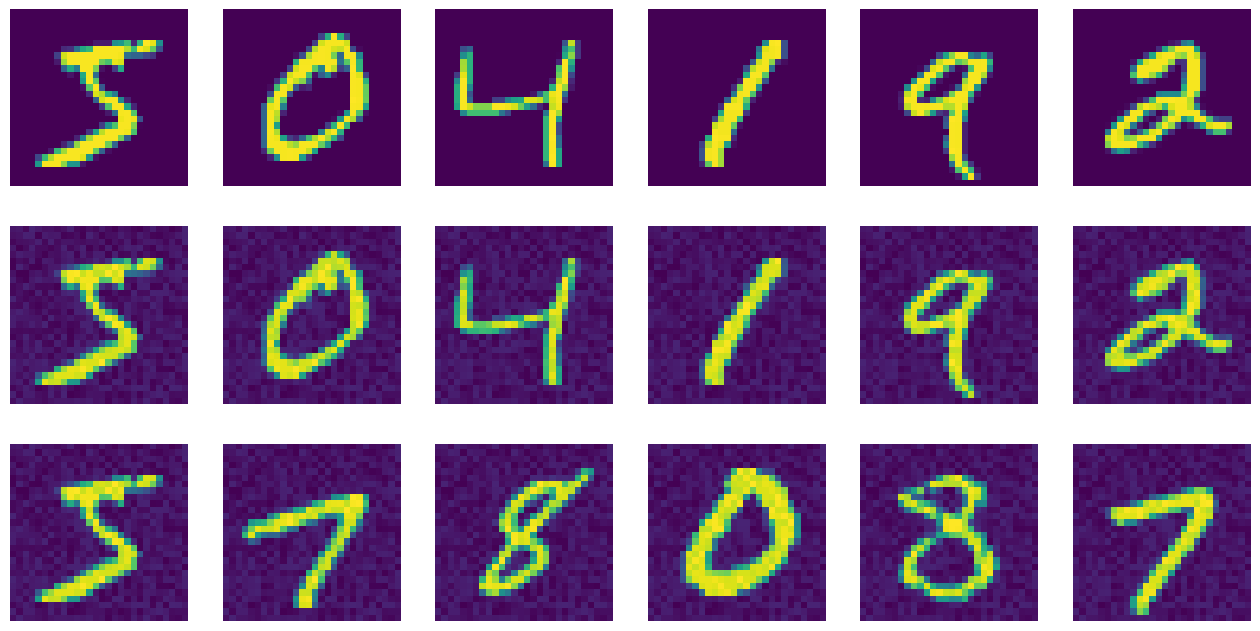

In [53]:
k = 2
# key = keys[k]
key = '0488'
info = infos[key]
model = models[key]
attack_specification = specifications[key]

print(json.dumps(info, indent=4))

fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(16, 8))

for i in range(6):
    # First visualize an image without the trigger and with the trigger
    img = clean_dataset[i][0].unsqueeze(0)
    attack_specification = attack_specification
    img_with_trigger, _ = utils.insert_trigger(img, attack_specification)
    ax[0, i].imshow(img.squeeze(0).permute(1,2,0).numpy())
    ax[0, i].axis('off')
    ax[1, i].imshow(img_with_trigger.squeeze(0).permute(1,2,0).numpy())
    ax[1, i].axis('off')
    # Now visualize another image with the same trigger
    img = clean_dataset[100*i+i][0].unsqueeze(0)
    img_with_trigger, _ = utils.insert_trigger(img, attack_specification)
    ax[2, i].imshow(img_with_trigger.squeeze(0).permute(1,2,0).numpy())
    ax[2, i].axis('off')

plt.show()

## Побробуем собрать датасет при помощи кластеризации активаций

In [16]:
keys_by_trig_type = {
    "patch": diploma_utils.filter_by_trigger_type("patch", infos),
    "blended": diploma_utils.filter_by_trigger_type("blended", infos)
} 

In [17]:
batch_size = 300
num_epochs = 10  # for training
number_of_classes = 10

In [18]:
dim_reduction_method = 'FastICA'
nb_clusters = 6
nb_dims = 12
silhouette_threshold = 0.12


In [19]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, f1_score
import pickle
import catboost

In [72]:
columns = ["key", "nb_classes", "nb_dims", "nb_clusters", "image_size"]
c2i = {col: i for i, col in enumerate(columns)}

In [79]:
def fill_dataframe(key, ac_result):
    df = np.empty((len(clean_dataset), len(columns)))
    df[:, c2i["key"]] = key
    df[:, c2i["nb_classes"]] = number_of_classes
    df[:, c2i["nb_dims"]] = nb_dims
    df[:, c2i["nb_clusters"]] = nb_clusters
    df[:, c2i["image_size"]] = np.prod(clean_dataset[0][0].shape)

    pdf = pd.DataFrame(df, columns=columns)
    return pdf.assign(**ac_result)

In [650]:
models[key]

MNIST_Network(
  (main): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1568, out_features=128, bias=True)
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
train_keys, test_keys = train_test_split(keys_by_trig_type["patch"])
train_keys_b, test_keys_b = train_test_split(keys_by_trig_type["blended"])
train_keys += train_keys_b
test_keys += test_keys_b

with open('mnist_train_keys.pkl', 'wb') as f:
    pickle.dump(train_keys, f)
    
with open('mnist_test_keys.pkl', 'wb') as f:
    pickle.dump(test_keys, f)


In [671]:
train_df = None
test_df = None

train_lables = []
test_lables = []
fm = []
reduced_fm = []
for t in ['train', 'test']:
    for key in tqdm(train_keys if t == 'train' else test_keys, leave=False):
        dataset, result = diploma_utils.get_ac_result(models[key], specifications[key], clean_dataset)
        fm.append(result['all_fm'])
        reduced_fm.append(result['all_reduced_fm'])
        diploma_utils.fix_features(result)
        pdf = fill_dataframe(key, result)
        cur_lables = np.zeros(len(dataset,))
        cur_lables[dataset.poisoned_indices] = 1
        
        if t == 'train':
            if train_df is not None:
                train_df = pd.concat([train_df, pdf], ignore_index=True, copy=False)
            else:
                train_df = pdf
                
            train_lables.append(cur_lables)
        else:
            if test_df is not None:
                test_df = pd.concat([test_df, pdf], ignore_index=True, copy=False)
            else:
                test_df = pdf
                
            test_lables.append(cur_lables)

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [679]:
train_df.tail()

,key,nb_classes,nb_dims,nb_clusters,image_size,all_pred_label,all_clusters,all_sample_silhuette,all_sample_distance_to_cluster_centroid,all_sample_mean_distance_to_cluster_centroid_amoung_cluster,all_sample_relative_cluster_size,all_sample_activation_norm,all_sample_min_distance_to_other_classes,classifier_ensurance_second,classifier_ensurance_first,min_img_dist_to_cluster_means_is_from_the_same_class,min_img_dist_to_cluster_means
5579995,454.0,10.0,12.0,6.0,784.0,8,2,0.060623,0.066648,0.000000e+00,2.709497,1.033091e-320,1.897889,0.000010,0.999982,True,89.488091
5579996,454.0,10.0,12.0,6.0,784.0,3,1,0.071000,0.141846,0.000000e+00,2.562714,2.817360e-319,2.708537,0.000034,0.999944,True,86.347054
5579997,454.0,10.0,12.0,6.0,784.0,5,4,0.077964,0.076156,1.482197e-321,3.075374,2.238513e-319,3.214460,0.000001,0.999997,True,88.478554
5579998,454.0,10.0,12.0,6.0,784.0,6,2,0.070673,0.065260,1.749182e-309,2.572851,1.517177e-319,2.261967,0.000057,0.999774,True,86.276970
5579999,454.0,10.0,12.0,6.0,784.0,8,0,0.060623,0.066648,6.281108e-312,3.675654,1.402702e-319,3.232472,0.000003,0.999991,False,85.296310


In [82]:
specifications[0] = None

In [682]:
# сконкатинируем целевые лейблы в один numpy массив
train_lables_1d = np.concatenate(train_lables)
test_lables_1d = np.concatenate(test_lables)

In [420]:

def get_poisoned_dataset(clean_dataset, attack_specification, poisoned_indices=None):
    if attack_specification is None:
        return clean_dataset

    poisoned_dataset = utils.PoisonedDataset(clean_dataset, attack_specification)

    if poisoned_indices is not None:
        poisoned_dataset.poisoned_indices = poisoned_indices

    return poisoned_dataset

def get_min_img_dist_to_cluster_means_feature(
    keys,
    df,
    original_is_poisoned,
    clean_dataset,
    specifications,
    batch_size=1000,
    num_workers=0    
):
    # original_lables may be poisoned if dataset is
    all_feature = []
    is_from_the_same_class_feature = []
    image_shape = clean_dataset[0][0].shape
    for key in tqdm(keys):
        attack_specification = specifications[key]
        poisoned_dataset = get_poisoned_dataset(
            clean_dataset,
            attack_specification,
            poisoned_indices=original_is_poisoned[df.key == int(key)].nonzero()[0])

        class_cluster_to_id : dict[tuple[int, int], int] = {} 
        cluster_means_images = torch.zeros((num_classes * nb_clusters, *image_shape))
        

        # получаем кластера для каждого класса и усредняем их
        cur_key_dataset = df[df.key == int(key)]
        for target_class in range(num_classes):
            for cluster_i in range(nb_clusters):
                images_for_cluster_idx = (
                    (cur_key_dataset.all_pred_label == target_class) 
                    & (cur_key_dataset.all_clusters == cluster_i)).values.nonzero()[0]
                
                dev_dataloader = torch.utils.data.DataLoader(
                    Subset(poisoned_dataset, images_for_cluster_idx),
                    batch_size=batch_size, shuffle=False, num_workers=num_workers)

                mean_image = torch.zeros(image_shape)
                for images_set, _ in dev_dataloader:
                    mean_image += images_set.sum(dim=0)
                mean_image = mean_image / images_for_cluster_idx.shape[0]
                ind = target_class * nb_clusters + cluster_i
                class_cluster_to_id[(target_class, cluster_i)] = ind
                cluster_means_images[ind] = mean_image

        dev_dataloader = torch.utils.data.DataLoader(
            poisoned_dataset,
            batch_size=batch_size, shuffle=False, num_workers=num_workers)
        cur_key_dataset_val = cur_key_dataset.loc[:, ["all_pred_label", "all_clusters"]].values
        
        for i, (images_set, _) in enumerate(dev_dataloader):
            img_infos = cur_key_dataset_val[i * batch_size : i * batch_size + len(images_set)]
            min_dists = torch.cdist(images_set.flatten(1), cluster_means_images.flatten(1), p=1)
            # global md
            # global ind_md
            # md = min_dists
            # ind_md = np.column_stack(
                    # (np.arange(0, len(img_infos)), (img_infos[:, 0] * nb_clusters + img_infos[:, 1]))
                # )
            # return
            min_dists[
                np.arange(0, len(img_infos)), (img_infos[:, 0] * nb_clusters + img_infos[:, 1])
            ] = torch.inf
            min_dists = torch.nan_to_num(min_dists, nan=torch.inf)
            all_feature.append(min_dists.min(dim=1).values.numpy())
            # print(min_dists.argmin(dim=1))
            is_from_the_same_class_feature.append(np.equal((min_dists.argmin(dim=1) // nb_clusters).numpy(), img_infos[:, 0]))

    return np.concatenate(all_feature), np.concatenate(is_from_the_same_class_feature)
    # return np.concatenate(is_from_the_same_class_feature)



In [424]:
train_min_img_dist_to_cluster_means, f2train = get_min_img_dist_to_cluster_means_feature(
    train_keys, train_df, train_lables_1d, clean_dataset, specifications)
test_min_img_dist_to_cluster_means, f2test = get_min_img_dist_to_cluster_means_feature(
    test_keys, test_df, test_lables_1d, clean_dataset, specifications)

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [428]:
train_df = train_df.assign(min_img_dist_to_cluster_means=train_min_img_dist_to_cluster_means)
test_df = test_df.assign(min_img_dist_to_cluster_means=test_min_img_dist_to_cluster_means)
train_df = train_df.assign(min_img_dist_to_cluster_means_is_from_the_same_class=f2train)
test_df = test_df.assign(min_img_dist_to_cluster_means_is_from_the_same_class=f2test)

In [261]:
train_df.shape

(5640000, 14)

In [431]:
test_df.head()

,key,nb_classes,nb_dims,nb_clusters,image_size,classifier_ensurance,all_pred_label,all_clusters,all_sample_silhuette,all_sample_distance_to_cluster_centroid,all_sample_mean_distance_to_cluster_centroid_amoung_cluster,all_sample_relative_cluster_size,all_sample_activation_norm,all_sample_min_distance_to_other_classes,min_img_dist_to_cluster_means,min_img_dist_to_cluster_means_is_from_the_same_class
0,387.0,10.0,12.0,6.0,784.0,0.999604,5,3,0.079435,6.907102e-310,6.907102e-310,6.907102e-310,6.907102e-310,3.551152,91.83051,True
1,387.0,10.0,12.0,6.0,784.0,0.999969,0,3,0.077574,4.678293e-310,4.678300e-310,4.678300e-310,4.678293e-310,2.310880,78.66423,True
2,387.0,10.0,12.0,6.0,784.0,0.999836,4,0,0.064867,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.309898,102.92992,True
3,387.0,10.0,12.0,6.0,784.0,0.999934,1,1,0.268135,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.057232,78.71430,True
4,387.0,10.0,12.0,6.0,784.0,0.999920,9,1,0.075992,7.767784e-02,-7.969057e-19,2.682990e+00,7.047378e-02,2.510611,70.20237,True


In [30]:
test_df_cleared = test_df.drop(["key", 'all_clusters', 'all_pred_label'], axis=1)
train_df_cleared = train_df.drop(["key", 'all_clusters', 'all_pred_label'], axis=1)

In [31]:
model = CatBoostClassifier(verbose=30, auto_class_weights="Balanced", iterations=100)
# train the model
model.fit(train_df_cleared, train_lables_1d)


Learning rate set to 0.5
0:	learn: 0.3664328	total: 221ms	remaining: 21.9s
30:	learn: 0.0677385	total: 4.58s	remaining: 10.2s
60:	learn: 0.0582984	total: 8.85s	remaining: 5.66s
90:	learn: 0.0544705	total: 13.1s	remaining: 1.3s
99:	learn: 0.0536070	total: 14.5s	remaining: 0us


In [32]:
preds_class = model.predict(test_df_cleared)
preds_proba = model.predict_proba(test_df_cleared)
print("class = ", preds_class)
print("proba = ", preds_proba)


class =  [0. 0. 0. ... 0. 0. 0.]
proba =  [[9.99810444e-01 1.89556334e-04]
 [9.99995756e-01 4.24375538e-06]
 [9.99924315e-01 7.56848553e-05]
 ...
 [9.99975153e-01 2.48470615e-05]
 [9.99997088e-01 2.91234114e-06]
 [9.99996284e-01 3.71633810e-06]]


In [33]:
# при обучении только на одном виде патча
# видно явное переобучение, all_clusters сама по себе не является важной фичей
# возможно это полечится с увеличением количества данных для обучения

print(f"{roc_auc_score(test_lables_1d, preds_proba[:, 1])=}")
print(f"{f1_score(test_lables_1d, preds_class)=}")

roc_auc_score(test_lables_1d, preds_proba[:, 1])=0.9980345081696688
f1_score(test_lables_1d, preds_class)=0.8924962924488169


In [712]:
model.get_feature_importance()

array([ 0.        ,  0.        ,  0.        ,  0.        , 37.91654741,
        4.24581768,  1.22697694,  0.8333016 ,  1.50645805, 15.87660679,
       11.03209091, 12.43667207,  6.02927104,  8.89625751])

In [713]:
train_df_cleared.columns[model.get_feature_importance() > 0]

Index(['all_sample_silhuette', 'all_sample_distance_to_cluster_centroid',
       'all_sample_mean_distance_to_cluster_centroid_amoung_cluster',
       'all_sample_relative_cluster_size', 'all_sample_activation_norm',
       'all_sample_min_distance_to_other_classes',
       'classifier_ensurance_second', 'classifier_ensurance_first',
       'min_img_dist_to_cluster_means_is_from_the_same_class',
       'min_img_dist_to_cluster_means'],
      dtype='object')

In [450]:
# Посчитаем ROC-AUC оригинального AC
print(f"{roc_auc_score(test_lables_1d, test_df_cleared.all_sample_silhuette.values)=}")

roc_auc_score(test_lables_1d, test_df_cleared.all_sample_silhuette.values)=0.9419951268114632


In [728]:
print(f"{f1_score(test_lables_1d, test_df_cleared.all_sample_silhuette.values > 0.13)=}")

f1_score(test_lables_1d, test_df_cleared.all_sample_silhuette.values > 0.13)=0.634411496941013


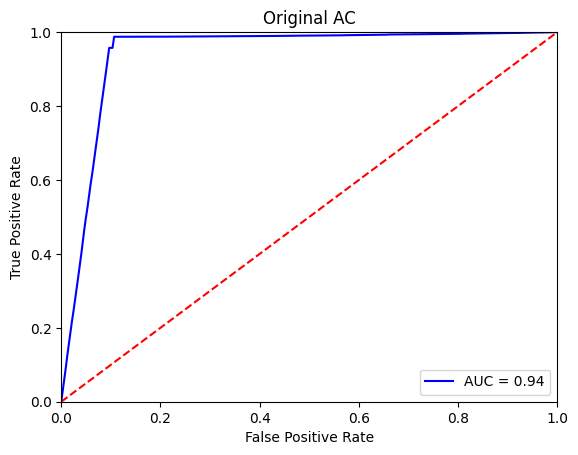

In [732]:
import sklearn.metrics as metrics

# probs = model.predict_proba(X_test)
# preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_lables_1d, test_df_cleared.all_sample_silhuette.values)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Original AC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

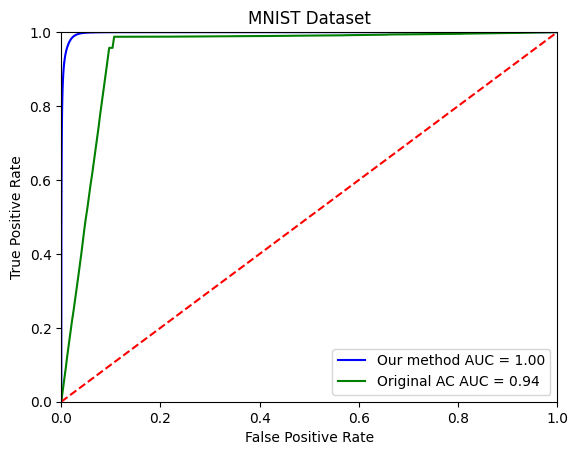

In [34]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(test_lables_1d, preds_proba[:, 1])
roc_auc = metrics.auc(fpr, tpr)

fpr_orig, tpr_orig, threshold_orig = metrics.roc_curve(test_lables_1d, test_df_cleared.all_sample_silhuette.values)
roc_auc_orig = metrics.auc(fpr_orig, tpr_orig)

plt.title('MNIST Dataset')
plt.plot(fpr, tpr, 'b', label = 'Our method AUC = %0.2f' % roc_auc)
plt.plot(fpr_orig, tpr_orig, 'g', label = 'Original AC AUC = %0.2f' % roc_auc_orig)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

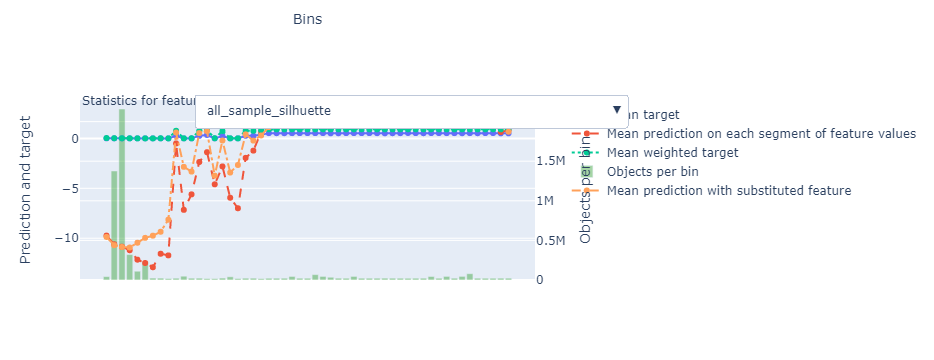

In [723]:
model.calc_feature_statistics(train_df_cleared, target=train_lables_1d, plot_file="mnist_features_stat.svg", plot=False)
print()

In [345]:
for t in np.arange(0.8, 1, 0.01):
    preds_prob = model.predict_proba(test_df_cleared)[:, 1]
    print(f"{t=} {f1_score(test_lables_1d, preds_prob>t)=}")

t=0.8 f1_score(test_lables_1d, preds_prob>t)=0.898968898029952
t=0.81 f1_score(test_lables_1d, preds_prob>t)=0.8991378880749488
t=0.8200000000000001 f1_score(test_lables_1d, preds_prob>t)=0.8993915699694534
t=0.8300000000000001 f1_score(test_lables_1d, preds_prob>t)=0.8996686640464122
t=0.8400000000000001 f1_score(test_lables_1d, preds_prob>t)=0.8998821847182503
t=0.8500000000000001 f1_score(test_lables_1d, preds_prob>t)=0.8996156460608143
t=0.8600000000000001 f1_score(test_lables_1d, preds_prob>t)=0.8993637427256784
t=0.8700000000000001 f1_score(test_lables_1d, preds_prob>t)=0.8989292815989395
t=0.8800000000000001 f1_score(test_lables_1d, preds_prob>t)=0.8983200662032779
t=0.8900000000000001 f1_score(test_lables_1d, preds_prob>t)=0.8976051359734546
t=0.9000000000000001 f1_score(test_lables_1d, preds_prob>t)=0.8961564781021898
t=0.9100000000000001 f1_score(test_lables_1d, preds_prob>t)=0.8946093403294436
t=0.9200000000000002 f1_score(test_lables_1d, preds_prob>t)=0.8923576397293287
t=0

In [452]:
model.save_model("mnist_all.cb")

In [793]:
train_df.to_csv("mnist_train.pd.csv")
test_df.to_csv("mnist_test.pd.csv")

In [794]:
np.save("mnist_test_lables_1d.np", test_lables_1d)
np.save("mnist_train_lables_1d.np", train_lables_1d)

In [40]:
# попробуем восстановить триггеры

In [21]:
train_df = pd.read_csv("mnist_train.pd.csv", index_col=0)
test_df = pd.read_csv("mnist_test.pd.csv", index_col=0)
test_lables_1d = np.load("mnist_test_lables_1d.np.npy")
train_lables_1d = np.load("mnist_train_lables_1d.np.npy")
model = CatBoostClassifier()
model.load_model("mnist_all.cb")

with open('mnist_train_keys.pkl', "rb") as f:
    train_keys = pickle.load(f)
    
with open('mnist_test_keys.pkl', "rb") as f:
    test_keys = pickle.load(f)
    

In [456]:
test_df.head()

,key,nb_classes,nb_dims,nb_clusters,image_size,classifier_ensurance,all_pred_label,all_clusters,all_sample_silhuette,all_sample_distance_to_cluster_centroid,all_sample_mean_distance_to_cluster_centroid_amoung_cluster,all_sample_relative_cluster_size,all_sample_activation_norm,all_sample_min_distance_to_other_classes,min_img_dist_to_cluster_means,min_img_dist_to_cluster_means_is_from_the_same_class
0,387.0,10.0,12.0,6.0,784.0,0.999604,5,3,0.079435,6.907102e-310,6.907102e-310,6.907102e-310,6.907102e-310,3.551152,91.83051,True
1,387.0,10.0,12.0,6.0,784.0,0.999969,0,3,0.077574,4.678293e-310,4.678300e-310,4.678300e-310,4.678293e-310,2.310880,78.66423,True
2,387.0,10.0,12.0,6.0,784.0,0.999836,4,0,0.064867,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.309898,102.92992,True
3,387.0,10.0,12.0,6.0,784.0,0.999934,1,1,0.268135,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.057232,78.71430,True
4,387.0,10.0,12.0,6.0,784.0,0.999920,9,1,0.075992,7.767784e-02,-7.969057e-19,2.682990e+00,7.047378e-02,2.510611,70.20237,True


In [22]:
def get_filtered_data(dataloader, mask=None, predicted_lables=None, filter_lable=None):
    """Return samples that is True in mask"""
    j = 0
    for imgs, lable in dataloader:
        for i in range(imgs.shape[0]):
            if (
                (mask is None or mask[j]) 
                and (filter_lable is None or (
                    (
                        predicted_lables is None and
                        filter_lable == lable[i].item()
                    ) or (
                        predicted_lables is not None and
                        filter_lable == predicted_lables[j]
                    )
                ))
            ):
                yield imgs[i]
            j += 1

In [24]:
class PoisonedDataset(torch.utils.data.Dataset):
    def __init__(self, clean_data, target_lable, triggers, masks, cluster_means):
        super().__init__()
        self.clean_data = clean_data
        self.target_lable = target_lable
        self.triggers = triggers
        self.masks = masks
        self.cluster_means = cluster_means
        self.means_without_trigger = self.cluster_means - self.triggers

    def __getitem__(self, idx):
        img, lable = self.clean_data[idx]
        
        if lable == self.target_lable:
            return img, lable
        else:
            ## Применяем триггер из наиболее близкого по усредненному изображению к текущему изображению
            ### Определяем наиболее близкое усреднённое изображение
            axis = tuple(range(1, len(self.cluster_means.shape)+1))
            trigger_id = torch.argmin(torch.norm(
                self.means_without_trigger - img.unsqueeze(0), dim=tuple(range(1, len(self.cluster_means.shape))), p=1)) # L1 metric
            trig_plus_image = img.cpu() * (1-self.masks[trigger_id].cpu()) + self.triggers[trigger_id].cpu() * self.masks[trigger_id].cpu()
            return trig_plus_image, self.target_lable

    def __len__(self):
        return len(self.clean_data)

In [25]:
from tqdm.notebook import tqdm

In [26]:
import trojanzoo_.torch_adopted.defenses.backdoor.model_inspection.neural_cleanse
importlib.reload(trojanzoo_.torch_adopted.defenses.backdoor.model_inspection.neural_cleanse)

NeuralCleanse = trojanzoo_.torch_adopted.defenses.backdoor.model_inspection.neural_cleanse.NeuralCleanse

def get_mask(nn_model, dev_dataloader, pattern, target_class):
    nn_cleanse = NeuralCleanse(
        nn_model,
        list(range(10)),
        dev_dataloader,
        img_shape=[1, 28, 28],
        initial_pattern=pattern,
        defense_remask_epoch=3
    )
    nn_cleanse.optimize_mark(target_class, verbose=False)
    return nn_cleanse.mask


In [36]:
predicted_test_lables = model.predict(test_df_cleared)

In [ ]:

results = []
for key in tqdm(test_keys):
    # 1. по тесту выделяем триггеры
    # получаем отправленные изображения
    ## установи в PoisonedDataset poisoned_indices в соответствии с test_lables_1d
    attack_specification = specifications[key]
    poisoned_dataset = utils.PoisonedDataset(clean_dataset, attack_specification) 
    poisoned_dataset.poisoned_indices = test_lables_1d[test_df.key == int(key)].nonzero()[0]
    dev_dataloader = torch.utils.data.DataLoader(poisoned_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
    nn_model = models[key]
    nn_model = nn_model.eval()
    nn_model = nn_model.cuda()
    
    # получаем кластера для предсказанных отравленных изображений
    is_poisoned_pred = predicted_test_lables[test_df.key == int(key)].astype(bool)
    cur_key_dataset = test_df[test_df.key == int(key)]
    cur_key_dataset_pred_poisoned_part = cur_key_dataset[is_poisoned_pred]
    
    pred_poisoned_target_classes = cur_key_dataset_pred_poisoned_part.all_pred_label.unique()
    for target_class in pred_poisoned_target_classes:
        triggers = [] # cluster -> trigger
        masks = []
        cluster_means = [] # cluster -> mean image
        cur_key_class_dataset_pred_poisoned_part = cur_key_dataset_pred_poisoned_part[
            cur_key_dataset_pred_poisoned_part.all_pred_label == target_class]
        
        if cur_key_class_dataset_pred_poisoned_part.shape[0] < cur_key_dataset.shape[0] / 200:
            continue  # мы не хотим анализировать слишком маленькие кластера, поскольку это займёт много времени
        
        ### усредняем изображения для кластеров класса
        assert(cur_key_dataset.shape[0] == len(is_poisoned_pred))
        poisoned_images_pred = torch.stack(list(
            get_filtered_data(dev_dataloader, is_poisoned_pred, cur_key_dataset.all_pred_label.values, target_class)
        ))
        ### ещё раз применить фильтрацию для получения изображений конкретного кластера
        for cluster in cur_key_class_dataset_pred_poisoned_part.all_clusters.unique():
            poisonde_images_for_cluster = poisoned_images_pred[
               (cur_key_class_dataset_pred_poisoned_part.all_clusters == cluster).values
            ]
            samples_cnt = poisonde_images_for_cluster.shape[0]
            mean_image = poisonde_images_for_cluster.sum(axis=0) / samples_cnt
            trigger_filtered = torch.where(
                (mean_image >= (mean_image.max()-0.1)) 
                | (mean_image <= 0.1), mean_image, torch.zeros_like(mean_image)
            )
            triggers.append(trigger_filtered)
            masks.append(get_mask(nn_model, dev_dataloader, trigger_filtered, target_class))
            cluster_means.append(mean_image)
            
        triggers = torch.stack(triggers)
        masks = torch.stack(masks)
        cluster_means = torch.stack(cluster_means)

        # 2. применяем триггеры к чистому датасету
        my_poisoned_dataset = PoisonedDataset(clean_dataset, target_class, triggers, masks, cluster_means)
        my_poisoned_loader = torch.utils.data.DataLoader(my_poisoned_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
        
    
        # 3. смотрим качество отравления
        _, attack_success_rate = utils.evaluate(my_poisoned_loader, nn_model)

        print(f"{attack_success_rate=}\n{target_class=}\n{key=}\n")
        results.append((attack_success_rate, target_class, key, masks, triggers, cluster_means))
    


  0%|          | 0/32 [00:00<?, ?it/s]

attack_success_rate=1.0
target_class=1
key='0387'

attack_success_rate=1.0
target_class=9
key='0376'

attack_success_rate=1.0
target_class=9
key='0430'

attack_success_rate=1.0
target_class=3
key='0415'

attack_success_rate=1.0
target_class=2
key='0385'

attack_success_rate=1.0
target_class=5
key='0389'

attack_success_rate=0.9999833333333333
target_class=3
key='0393'

attack_success_rate=1.0
target_class=9
key='0424'

attack_success_rate=0.9987166666666667
target_class=7
key='0424'

attack_success_rate=0.9999666666666667
target_class=1
key='0424'

attack_success_rate=1.0
target_class=3
key='0377'

attack_success_rate=1.0
target_class=0
key='0436'

attack_success_rate=0.9999833333333333
target_class=8
key='0408'

attack_success_rate=1.0
target_class=2
key='0391'

attack_success_rate=0.9998833333333333
target_class=4
key='0411'

attack_success_rate=0.9999833333333333
target_class=1
key='0395'

attack_success_rate=0.9996666666666667
target_class=5
key='0414'

attack_success_rate=1.0
targ

In [67]:
len(results)

34

In [69]:
with open("triggers_and_masks.pkl", "wb") as f:
    pickle.dump(results, f)

In [ ]:
raise Exception()

In [ ]:
prev_results = results

In [717]:
predicted_train_lables = model.predict(train_df)

In [719]:
my_poisoned_dataset = PoisonedDataset(clean_dataset, target_class, triggers, masks, cluster_means)
my_poisoned_loader = torch.utils.data.DataLoader(my_poisoned_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


# 3. смотрим качество отравления
_, attack_success_rate = utils.evaluate(my_poisoned_loader, nn_model)

print(f"{attack_success_rate=}\n{target_class=}\n{key=}")

attack_success_rate=0.9748333333333333
target_class=8
key='0426'


In [ ]:
cur_key_dataset

In [805]:
triggers = triggers[0]

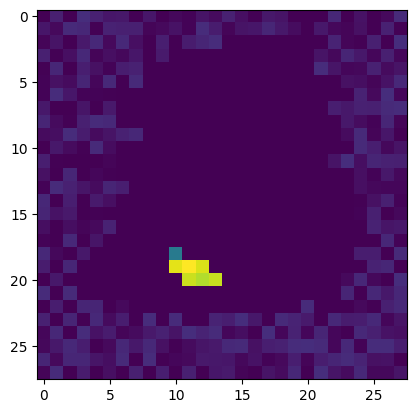

In [38]:
plt.imshow((triggers[0].cpu() * masks[0].cpu()).permute(1,2,0))

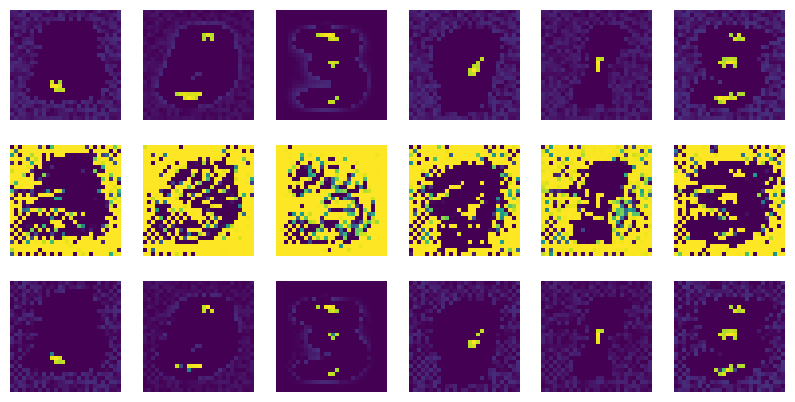

In [42]:
fig, ax = plt.subplots(nrows=3, ncols=len(cluster_means), figsize=(10, 5))

for i in range(len(cluster_means)):
    ax[0, i].imshow(triggers[i].cpu().permute(1,2,0).numpy())
    ax[0, i].axis('off')
    ax[1, i].imshow(masks[i].cpu().permute(1,2,0).numpy())
    ax[1, i].axis('off')
    ax[2, i].imshow((triggers[i].cpu() * masks[i].cpu()).permute(1,2,0).numpy())
    ax[2, i].axis('off')

plt.show()

In [43]:
target_class

3

In [55]:
key

'0488'

In [60]:
torch.norm(specifications[key]["trigger"]["pattern"] * specifications[key]["trigger"]["mask"] - triggers[4] * masks[4].cpu(), p=1)

tensor(368.2372)

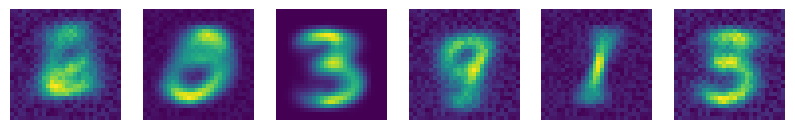

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=len(cluster_means), figsize=(10, 10))

for i in range(len(cluster_means)):
    ax[i].imshow(cluster_means[i].permute(1,2,0).numpy())
    ax[i].axis('off')

plt.show()

In [46]:
# 2. применяем триггеры к чистому датасету
my_poisoned_dataset = PoisonedDataset(clean_dataset, 1, triggers, masks, cluster_means)
my_poisoned_loader = torch.utils.data.DataLoader(my_poisoned_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# break

# 3. смотрим качество отравления
# _, attack_success_rate = utils.evaluate(my_poisoned_loader, nn_model)


In [63]:
i = 2
my_poisoned_img = my_poisoned_dataset[i + 100*i][0]
original_poisoned_img, _ = utils.insert_trigger(clean_dataset[i + 100*i][0], specifications[key])
torch.norm(my_poisoned_img - original_poisoned_img, p=1)

tensor(26.8652)

In [ ]:
torch.norm(specifications[key]["trigger"]["pattern"] * specifications[key]["trigger"]["mask"] - triggers[4] * masks[4].cpu(), p=1)

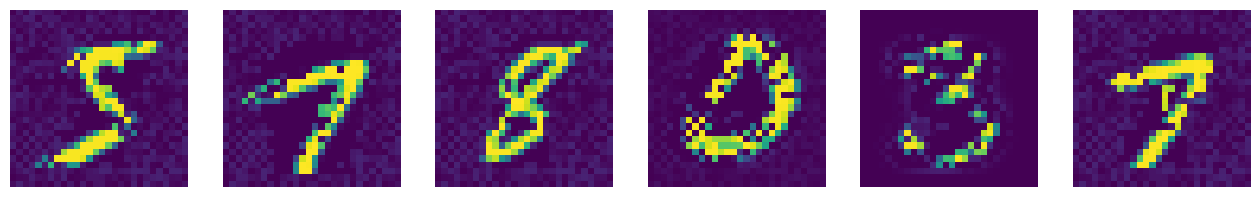

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(16, 8))

for i in range(6):
    img = my_poisoned_dataset[i + 100*i][0]
    ax[i].imshow(img.permute(1,2,0).numpy())
    ax[i].axis('off')